<h1>Review Classification using spaCy</h1>

**Import Dependencies**

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import spacy
from matplotlib import pyplot as plt
import seaborn as sns

**Load the spaCy English model**

In [2]:
nlp = spacy.load("en_core_web_sm")

**Load the dataset**

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

**Convert labels to binary: positive -> 1, negative -> 0**

In [4]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

**Divide the dataset into training, validation, and test sets**

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

**Create a text classification pipeline**

In [6]:
base_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

**Train the base model with default hyperparameters**

In [7]:
base_model.fit(train_df['review'], train_df['sentiment'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

**Evaluate the base model on the test set**

In [8]:
test_predictions = base_model.predict(test_df['review'])
test_accuracy = accuracy_score(test_df['sentiment'], test_predictions)
print("Test Accuracy (Base Model):", test_accuracy)
print(classification_report(test_df['sentiment'], test_predictions))

Test Accuracy (Base Model): 0.8608
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4961
           1       0.89      0.83      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


**Evaluate the base model on the validation set**

In [9]:
val_base_predictions = base_model.predict(val_df['review'])
val_base_accuracy = accuracy_score(val_df['sentiment'], val_base_predictions)
print("Validation Accuracy (Base Model):", val_base_accuracy)
print(classification_report(val_df['sentiment'], val_base_predictions))

Validation Accuracy (Base Model): 0.863
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3959
           1       0.89      0.83      0.86      4041

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.87      0.86      0.86      8000


**Define hyperparameters**

In [10]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Uni-gram and Bi-gram
    'tfidf__use_idf': [True, False],
    'classifier__alpha': [0.1, 0.01, 0.001, 0.0001]
}

**Perform hyperparameter tuning**

In [11]:
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(train_df['review'], train_df['sentiment'])
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Hyperparameters: {'classifier__alpha': 0.1, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


**Evaluate the tuned model on the test set**

In [12]:
test_predictions = best_model.predict(test_df['review'])
test_accuracy = accuracy_score(test_df['sentiment'], test_predictions)
print("Test Accuracy (Tuned Model):", test_accuracy)
print(classification_report(test_df['sentiment'], test_predictions))

Test Accuracy (Tuned Model): 0.8933
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4961
           1       0.90      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


**Evaluate the tuned model on the validation set**

In [13]:
val_predictions = best_model.predict(val_df['review'])
val_accuracy = accuracy_score(val_df['sentiment'], val_predictions)
print("Validation Accuracy (Tuned Model):", val_accuracy)
print(classification_report(val_df['sentiment'], val_predictions))

Validation Accuracy (Tuned Model): 0.89725
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      3959
           1       0.91      0.88      0.90      4041

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000


**Visualization of hyperparameter tuning**

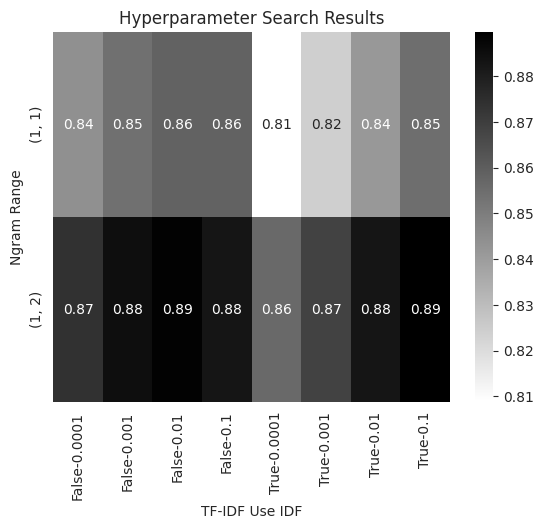

In [37]:
# Visualize hyperparameter search results using a heatmap
results = pd.DataFrame(grid_search.cv_results_)
pivot_results = results.pivot_table(index='param_vectorizer__ngram_range',
                                    columns=['param_tfidf__use_idf', 'param_classifier__alpha'],
                                    values='mean_test_score')
sns.heatmap(pivot_results, annot=True, cmap='binary')
plt.title('Hyperparameter Search Results')
plt.xlabel('TF-IDF Use IDF')
plt.ylabel('Ngram Range')
plt.show()

### Model testing

**Predict sentiment using the trained model**

In [33]:
# Input review
review = "This movie was great."

predicted_sentiment = best_model.predict([review])[0]
predicted_sentiment_label = 'positive' if predicted_sentiment == 1 else 'negative'
print("Predicted Sentiment:", predicted_sentiment_label)

Predicted Sentiment: positive
